# This is it IllRun project.

This project is used as example of use of statsmodels sklean on supervised learning to conclude the for-credit option for **Introduction to Machine Learning: Supervised Learning** (CSCA 5622-100)

The main idea is create a model and an application that will predict if I'll be running tomorrow or not. It wil use a cleaned version of [RungGap](https://www.rungap.com/) csv file from my runnings on last year.

This notebook was created with unlimited help of search on the web (**google** engine) and **Gemini Pro 2.5** to answer specific questions about programming and how to use the libraries.

Let's start with DATA analysis... (I cleaned the csv file before to remove personal data)

In [19]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt 
%matplotlib inline 
import statsmodels.formula.api as smf
import statsmodels.api as sm

#import file
df = pd.read_csv("rungap-export.csv")
print(f"total of activities: {len(df)}")

total of activities: 763


In [20]:
# other activities exported, let's filter only by running
df = df[df['activity'].str.contains('Running', case=False, na=False)]

# to make sure the date is balanced, its better to filter by date (let's consider last year)
df['local time'] = pd.to_datetime(df['local time'])
df = df[(df['local time'] >=  pd.to_datetime('2024-08-24')) & (df['local time'] <= pd.to_datetime('2025-08-26'))]
print(f"total of runnings: {len(df)}")
df.head()

total of runnings: 181


,local time,activity,activity id,source activity,duration(s),elapsed time(s),distance(m),calories(kcal),steps,avg speed(m/s),...,max heartrate,avg cadence,max cadence,avg power,max power,has GPS,min elevation(m),max elevation(m),elevationgain(m),elevationloss(m)
1,2025-08-25 11:37:00,Running,100,running,2154.14,2154.14,5749.90,463,5906,2.67,...,149,82,88,330,416,1,250,259,17,14
3,2025-08-23 09:44:00,Running,100,running,6266.04,6266.04,16767.08,1367,16456,2.68,...,165,78,88,319,518,1,241,260,77,77
4,2025-08-21 13:23:00,Running,100,running,1559.31,1559.31,5011.15,378,4068,3.21,...,169,76,86,387,542,1,250,261,15,16
5,2025-08-19 08:29:00,Running,100,running,4201.35,4219.16,11568.36,930,11294,2.75,...,167,79,88,334,472,1,245,261,39,41
6,2025-08-15 15:09:00,Running,100,running,5543.90,5543.90,12758.25,1114,13180,2.30,...,163,70,116,256,444,1,240,261,55,57


In [22]:
# Keep only relevant columns
df = df[['local time', 'duration(s)', 'distance(m)', 'avg heartrate']]

#let's standardize the date. I'll use a date of the year to take into account seasons
df['day_of_year'] = df['local time'].dt.dayofyear

Let's check the graph based on day of the year and the total of meters that I run... if there is two or more excersises in one specific day of the year, I will get the averange. And let's make sure all days ave value (add 0 to days that I didn't run)

In [28]:

df_filled = df.groupby('day_of_year').mean()
df_filled = df_filled.reindex(pd.RangeIndex(1, 366), fill_value=0)
df_filled = df_filled.reset_index()
df_filled = df_filled.rename(columns={'index': 'day_of_year'})
df_filled = df_filled.dropna(subset=['day_of_year'])

# if day is not runned, let's put the date of that day in 2024 (to get the weekday right)
mask = df_filled['distance(m)'] == 0

# as I'm using my runnings from 2024 and 2025, let's consider the day that course starts to cut between years
# so if day of year is > 238 (24th August), then we are in 2024, else in 2025

df_filled.loc[mask, 'local time'] = df_filled.loc[mask, 'day_of_year'].apply(
    lambda d: pd.to_datetime('2024-01-01') + pd.to_timedelta(d - 1, unit='D') if d > 238
    else pd.to_datetime('2025-01-01') + pd.to_timedelta(d - 1, unit='D')
)

#lets also add a new column that will say if I runned or not
df_filled['runned'] = df_filled['distance(m)'].apply(lambda x: 1 if x>0 else 0)
print(df_filled)

     day_of_year           local time  duration(s)   distance(m)  \
0              1  2025-01-01 14:18:00  1735.560000   3593.150000   
1              2  2025-01-02 09:10:00  1950.090000   5096.430000   
2              3  2025-01-03 11:21:00  2160.830000   5136.380000   
3              4  2025-01-04 00:00:00     0.000000      0.000000   
4              5  2025-01-05 09:35:00  2142.930000   5168.460000   
5              6  2025-01-06 00:00:00     0.000000      0.000000   
6              7  2025-01-07 09:25:00  2289.610000   5885.150000   
7              8  2025-01-08 14:01:00  2090.380000   5229.480000   
8              9  2025-01-09 00:00:00     0.000000      0.000000   
9             10  2025-01-10 00:00:00     0.000000      0.000000   
10            11  2025-01-11 00:00:00     0.000000      0.000000   
11            12  2025-01-12 00:00:00     0.000000      0.000000   
12            13  2025-01-13 11:06:00  3351.990000   8777.510000   
13            14  2025-01-14 00:00:00     0.0000

8/27/2024  1:41:15 PM has an entry with 0 meters... so it's fine

Text(0.5, 0, 'Day of the Year')

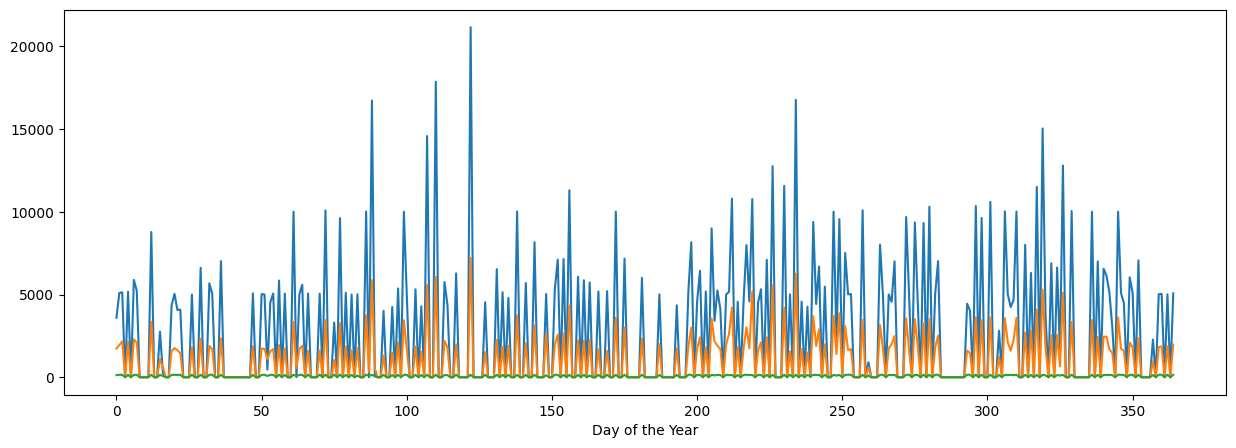

In [29]:
# let's plot a graph of the distance, time and HR avg by day of the year
plt.figure(figsize=(15,5))
plt.plot(df_filled.index, df_filled['distance(m)'], label='distance(m)')
plt.plot(df_filled.index, df_filled['duration(s)'], label='duration(s)')
plt.plot(df_filled.index, df_filled['avg heartrate'], label='avg heartrate')
plt.xlabel('Day of the Year')   

Let's create first a model that considere any distance as 1 (run) and only says if it will run or not. (im thinking to run a )

In [30]:
df_filled['runned_tomorrow'] = df_filled['runned'].shift(-1)
pd.set_option('display.max_rows', None)

# Now, printing the DataFrame will show all 100 rows
#print(df_filled)
model = smf.logit(formula='runned_tomorrow ~ day_of_year', data=df_filled)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.685839
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        runned_tomorrow   No. Observations:                  364
Model:                          Logit   Df Residuals:                      362
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 Aug 2025   Pseudo R-squ.:                0.003500
Time:                        18:08:24   Log-Likelihood:                -249.65
converged:                       True   LL-Null:                       -250.52
Covariance Type:            nonrobust   LLR p-value:                    0.1854
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.4423      0.213     -2.074      0.038      -0.860      -0.024
day_of_year     0.0013      0.001      1.321      0.186      -0.001       0.003
===============================================================================
"""

In [31]:
print(results.predict(pd.DataFrame({'day_of_year': [1, 32, 60, 120, 180, 240, 300, 365]})))

0    0.391520
1    0.401390
2    0.410374
3    0.429821
4    0.449487
5    0.469312
6    0.489235
7    0.510854
dtype: float64


Ok, this modelo is ready but it's weak.. considering only the current day to predict tomorow is not enought. Let's add two more dimensions on it:

1 - Runned today?
2 - Runned yesterda?
3 - day of week

In [32]:
#let's add a column with weeekday
df_filled['local time'] = pd.to_datetime(df_filled['local time'])
df_filled['weekday'] = df_filled['local time'].dt.dayofweek
df_filled['runned_today'] = df_filled['runned']
df_filled['runned_yesterday'] = df_filled['runned'].shift(1)

#runned_tomorrow is NaN on last day and #runned_yesteda is NaN on first, clean it.
df_filled = df_filled.dropna(subset=['runned_tomorrow', 'runned_yesterday'])
df_filled.tail()

,day_of_year,local time,duration(s),distance(m),avg heartrate,runned,runned_tomorrow,weekday,runned_today,runned_yesterday
359,360,2024-12-25 06:42:30,1826.155,5015.10,155.0,1,1.0,2,1,0.0
360,361,2024-12-26 08:10:00,1855.290,5037.21,149.0,1,0.0,3,1,1.0
361,362,2024-12-27 00:00:00,0.000,0.00,0.0,0,1.0,4,0,1.0
362,363,2024-12-28 08:43:00,1864.370,5012.94,152.0,1,0.0,5,1,0.0
363,364,2024-12-29 00:00:00,0.000,0.00,0.0,0,1.0,6,0,1.0


In [33]:
df_filled.head()

,day_of_year,local time,duration(s),distance(m),avg heartrate,runned,runned_tomorrow,weekday,runned_today,runned_yesterday
1,2,2025-01-02 09:10:00,1950.09,5096.43,144.0,1,1.0,3,1,1.0
2,3,2025-01-03 11:21:00,2160.83,5136.38,147.0,1,0.0,4,1,1.0
3,4,2025-01-04 00:00:00,0.00,0.00,0.0,0,1.0,5,0,1.0
4,5,2025-01-05 09:35:00,2142.93,5168.46,137.0,1,0.0,6,1,0.0
5,6,2025-01-06 00:00:00,0.00,0.00,0.0,0,1.0,0,0,1.0


Lets use ADABoost like we saw in week 5 to create a model that having these 3 features (runned_today, runned_yesterday and day_of_week), predict if runned_tomorrow

In [34]:
features = ['runned_today', 'runned_yesterday', 'weekday']
target = 'runned_tomorrow'
X = df_filled[features]
y = df_filled[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(y.value_counts())

runned_tomorrow
0.0    200
1.0    163
Name: count, dtype: int64


In [35]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42, estimator=DecisionTreeClassifier(max_depth=1))
adaboost_model.fit(X_train, y_train)

,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,100
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


let's get the predictions:

In [37]:
test_predictions = adaboost_model.predict(X_test)
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions
})
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']
print(results_df.head(100))

     Actual  Predicted  Correct
164     0.0        1.0    False
34      0.0        1.0    False
16      0.0        0.0     True
308     1.0        0.0    False
58      0.0        0.0     True
183     0.0        1.0    False
77      0.0        0.0     True
120     0.0        1.0    False
269     0.0        1.0    False
127     0.0        0.0     True
259     0.0        0.0     True
40      0.0        0.0     True
233     1.0        0.0    False
56      0.0        0.0     True
138     0.0        0.0     True
200     1.0        1.0     True
256     1.0        0.0    False
225     1.0        1.0     True
328     1.0        1.0     True
102     1.0        1.0     True
10      0.0        0.0     True
193     0.0        1.0    False
73      0.0        1.0    False
287     0.0        0.0     True
338     0.0        0.0     True
195     0.0        0.0     True
219     0.0        0.0     True
169     0.0        0.0     True
149     0.0        0.0     True
360     0.0        1.0    False
26      

Let's evaluate the performance of the last model

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

accuracy = accuracy_score(y_test, test_predictions)
print(f"accuracy: {accuracy:.2f}")

accuracy: 0.63


In [39]:
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68        47
         1.0       0.49      0.65      0.56        26

    accuracy                           0.63        73
   macro avg       0.62      0.64      0.62        73
weighted avg       0.66      0.63      0.64        73



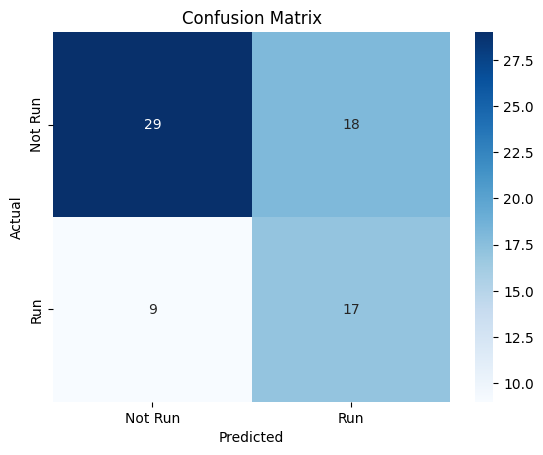

In [40]:
# let's check the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Run', 'Run'], yticklabels=['Not Run', 'Run'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Conclusion:** The model is not perfect and due to the limited amount of data, its feasible to what it is. But anyway, it's predicting if I'll be running or not tomorow based on my last year of running.

Nexts steps is adding the weather, getting the historic weather from the day and the forecast for tomorrow, this variable will probably bring much more useful insights.

One step further could be predict the distance or the duration of runnings